In [141]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [5]:
train_im_csv = pd.read_csv('../input/trash-containers/train_dataset_train/train.csv')
blur_imgs = train_im_csv[train_im_csv['class']==2] # possibly blurry
zero_class_imgs = train_im_csv[train_im_csv['class']==0]
first_class_imgs = train_im_csv[train_im_csv['class']==1]
train_image_path = '../input/trash-containers/train_dataset_train/train'
test_image_path = '../input/trash-containers/test_dataset_test'
blur_imgs.head(10)

,ID_img,class
102,220307011050_5e20cf51feb01506981f8c37bd3da5b6.jpg,2.0
103,220307011051_1c9b57d611d2a8a73e8d329cc4f9f18e.jpg,2.0
104,220307012717_4d221db014939a79f76539816d578863.jpg,2.0
105,220307012835_983e193301d76a2d1498a5f36beba908.jpg,2.0
106,220307013123_9d281d2e2e2c64a2077a372d69a37da0.jpg,2.0
107,220307013457_e82ef3f21f4f5ae8c3e58f7b1f68c379.jpg,2.0
108,220307013523_de874e46a1e3c812921ae4d4bc04a511.jpg,2.0
109,220307013601_6643532d77f0f624e1a2db7d462a34a2.jpg,2.0
110,220307013946_400cdaf7917e3a109bd4bff12a0322e4.jpg,2.0
111,220307014229_451c5e96d4ab7bc1387035fd1ae53a9a.jpg,2.0


In [6]:
val_csv = pd.read_csv('../input/trash-containers/annotations_test_visual.csv', index_col=0)
val_csv = val_csv.drop(columns=['id', 'annotator', 'created_at', 'updated_at', 'lead_time', 'annotation_id'])
val_csv = val_csv.rename(columns={'choice':'class'})
val_csv.index = val_csv.index.str.split('/').str[-1].str.split('-').str[-1]
val_csv.to_csv('./test_val.csv')

In [7]:
def get_img_var(df, images_path, print_vars=True,):
    img_count = 0.0
    mean_var = 0.0
    vars_list = []
    for i, row in df.iterrows():
        img_count += 1
        image = cv2.imread(f'{images_path}/{row.iloc[0]}')
        var = cv2.Laplacian(image, cv2.CV_64F).var()
        mean_var += var
        vars_list.append(var)
    #     print(var)
    mean_var = mean_var / img_count
    median = np.median(np.array(vars_list))
    std = np.std(np.array(vars_list))
    max_var = np.max(np.array(vars_list))
    
    if print_vars:
        print(mean_var)
        print(median)
        print(std)
        print(max_var)
    
    return mean_var, median, std, max_var 

get_img_var(blur_imgs, train_image_path)

111.61990417155518
37.096175390936956
294.2158613859769
2188.4213077334916


(111.61990417155518, 37.096175390936956, 294.2158613859769, 2188.4213077334916)

In [26]:
def get_laplacian_var(img_name, image_path='../input/trash-containers/test_dataset_test'):
    image = cv2.imread(f'{image_path}/{img_name}')
    var = cv2.Laplacian(image, cv2.CV_64F).var()
    return var

In [ ]:
blur_imgs_val = val_csv[val_csv['class'] == 1].reset_index()

In [ ]:
get_img_var(blur_imgs_val, test_image_path)

In [114]:
def detect_blur_fft(image, size=60):
    # grab the dimensions of the image and use the dimensions to
    # derive the center (x, y)-coordinates
    (h, w) = image.shape
    (cX, cY) = (int(w / 2.0), int(h / 2.0))
    # compute the FFT to find the frequency transform, then shift
    # the zero frequency component (i.e., DC component located at
    # the top-left corner) to the center where it will be more
    # easy to analyze
    fft = np.fft.fft2(image)
    fftShift = np.fft.fftshift(fft)
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)
    magnitude = 20 * np.log(np.abs(recon))
    mean = np.mean(magnitude)
    # the image will be considered "blurry" if the mean value of the
    # magnitudes is less than the threshold value
    plt.imshow(image, cmap='gray')
    return mean

In [ ]:
detect_blur_fft(cv2.imread(f'{test_image_path}/{blur_imgs_val.iloc[32,0]}', 0))

# Detect blur in our images

In [ ]:
val_csv['var'] = val_csv.apply(lambda x: get_laplacian_var(x.name), axis=1)

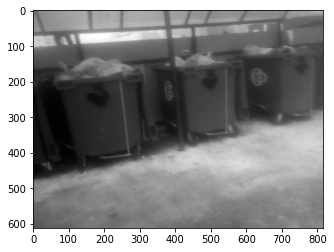

In [115]:
val_csv['mag_mean'] = val_csv.apply(lambda x: detect_blur_fft(cv2.imread(f'../input/trash-containers/test_dataset_test/{x.name}', 0)), axis=1)

In [135]:
val_csv['class'].value_counts() # 190

1    151
0     39
2     35
Name: class, dtype: int64

In [167]:
# val_csv['pred_2'] = val_csv.apply(lambda x: 2 if x['var'] < 250 else 0 , axis=1)
val_csv['pred_2'] = val_csv.apply(lambda x: 2 if x['mag_mean'] < 15 else 0 , axis=1)

In [168]:
val_csv[(val_csv['class']==2) & (val_csv['class'] == val_csv['pred_2'])].info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 33437125596_39258982967_26350783647_4.jpg to 53769398476_24657825276_20812383348_8.jpg
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   class     23 non-null     int64  
 1   var       23 non-null     float64
 2   pred_2    23 non-null     int64  
 3   mag_mean  23 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 920.0+ bytes


In [169]:
val_csv['pred_2'].value_counts()

0    158
2     67
Name: pred_2, dtype: int64

<AxesSubplot:>

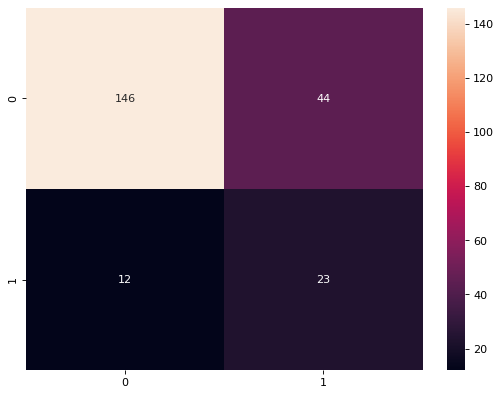

In [170]:
pred = val_csv['pred_2'].values
real = val_csv['class'].replace({1:0}).values

matrix = confusion_matrix(real, pred)
matrix.diagonal()/matrix.sum(axis=0)

plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(matrix, annot=True, fmt='d')

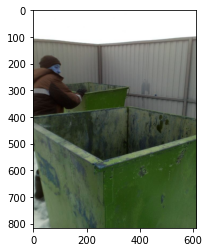

In [112]:
img_p = '39875609337_70856687487_64538955318_4.jpg'
plt.imshow(cv2.imread(f'../input/trash-containers/test_dataset_test/{img_p}'))